# Song Classification

In [1]:
# Run this cell to set up the notebook, but please don't change it.

import numpy as np
import math
from datascience import *

# These lines set up the plotting functionality and formatting.
import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Lyric Data

In [2]:
# Get lyrics
lyrics = Table.read_table('lyrics.csv').sample(with_replacement=False)

words = lyrics.drop(np.arange(3)).labels
titles = lyrics.column('Title')

num_words = len(words)
num_songs = len(titles)

num_valid = 400
test_lyrics = lyrics.take(np.arange(0, num_valid))
train_lyrics = lyrics.take(np.arange(num_valid, num_songs))

print("Number of Words: %d" % (num_words))
print("Number of Songs: %d" % (num_songs))
print("Training Size: %d" % (train_lyrics.num_rows))
print("Testing Size: %d" % (test_lyrics.num_rows))

# Retrieves row that corresponds to title
title_index = lyrics.index_by('Title')
def row_for_title(title):
    """Return the row for a title, similar to the following expression (but faster)
    
    lyrics.where('Title', title).row(0)
    """
    return title_index.get(title)[0]

# Print sample songs
Table().with_column(
    'Title', titles
).show(4)

Number of Words: 4817
Number of Songs: 1721
Training Size: 1321
Testing Size: 400


Title
I Think About You
The Cigar Song
Hillbilly Fever
L.I.F.E.


In [3]:
holdout = Table.read_table('holdout.csv').drop('Id')
holdout.select(0, 1, 2, 3, 4).show(5)

i,the,you,to,and
0.039627,0.013986,0.0862471,0.025641,0.0559441
0.0760563,0.101408,0.0056338,0.0056338,0.0140845
0.0163934,0.0655738,0,0,0.0491803
0.0643777,0.0472103,0.00429184,0.0429184,0.0343348
0.0346021,0.0242214,0,0,0.0519031


## TF-IDF

In [31]:
# Get document frequency
def document_frequency(word):
    return np.count_nonzero(lyrics.column(word) > 0) + np.count_nonzero(holdout.column(word) > 0)

# Get document frequencies
def document_frequencies():
    return Table().with_column('Word', words).apply(document_frequency, 'Word')

# Get inverse document frequencies
def generate_idf():
    frequencies = document_frequencies()
    return np.log(num_songs / (frequencies + 1))

# Get tfidf table
def tfidf(tf):
    return tf * idf


### Vector of document frequencies for words
idf = generate_idf()

In [32]:
### TESTING: TF-IDF

sample_song_title = test_lyrics.column('Title').item(5)
print("Song: ", sample_song_title)
Table().with_columns(
    'Word', words,
    'tf-idf', tfidf(row_for_title(sample_song_title)[3:])
).sort('tf-idf', descending=True)

Song:  Jacob's Ladder


Word,tf-idf
ladder,0.404207
higher,0.296773
climb,0.286905
sister,0.225423
brother,0.148923
stronger,0.148387
circl,0.145834
everi,0.116682
danc,0.0951132
goe,0.0911722


# PCA

In [10]:
from sklearn.decomposition import PCA

In [277]:
train_data = np.array([list(r) for r in train_lyrics.drop(np.arange(3)).rows])
print(train_data.shape)

test_data = np.array([list(r) for r in test_lyrics.drop(np.arange(3)).rows])
print(test_data.shape)

holdout_data = np.array([list(r) for r in holdout.rows])
print(holdout_data.shape)

full_data = np.concatenate((train_data, test_data), axis=0)
print(full_data.shape)

pca = PCA()
pca.fit(train_data)

(1321, 4817)
(400, 4817)
(100, 4817)
(1721, 4817)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

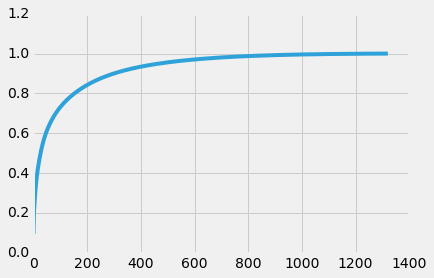

In [273]:
variances = pca.explained_variance_ratio_
variances = np.cumsum(variances)
plt.plot(range(len(variances)), variances)

In [278]:
n_components = 400
pca = PCA(n_components)
train_pca_data = pca.fit_transform(train_data)
test_pca_data = pca.transform(test_data)
holdout_pca_data = pca.transform(holdout_data)
print(train_pca_data.shape)
print(test_pca_data.shape)
print(holdout_pca_data.shape)

(1321, 400)
(400, 400)
(100, 400)


# K-NN

In [279]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    In case of a tie, it returns any one of the most common values
    """
    return table.group(label).sort('count', descending = True).column(label).item(0)

def fast_distances(test_row, train_rows):
    """An array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test song (e.g., test_20.row(0)).
      train_rows: A table of features (for example, the whole
        table train_20)."""
    counts_matrix = train_rows
    diff = np.tile(test_row, [counts_matrix.shape[0], 1]) - counts_matrix
    distances = np.squeeze(np.asarray(np.square(diff).sum(1)))
    return distances

In [280]:
def classify(test_row, train_rows, train_classes, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_rows)
    genre_and_distances = Table().with_columns(
        'Class', train_classes,
        'Distance', distances
    ).sort('Distance')
    return most_common('Class', genre_and_distances.take(np.arange(k)))

In [281]:
def classify_knn(row, k = 3):
    return classify(row, train_pca_data, train_lyrics.column('Genre'), k)

In [282]:
guesses = np.array([])
for test_row in test_pca_data:
    guesses = np.append(guesses, classify_knn(test_row))
proportion_correct = np.count_nonzero(guesses == test_lyrics.column('Genre')) / test_lyrics.num_rows
proportion_correct

0.54

In [284]:
pca = PCA(n_components)
full_pca_data = pca.fit_transform(full_data)
holdout_pca_data = pca.transform(holdout_data)
print(full_pca_data.shape)
print(holdout_pca_data.shape)

def classify_full_knn(row):
    return classify(row, full_pca_data, lyrics.column('Genre'), 3)

(1721, 400)
(100, 400)


In [285]:
holdout_predictions = []
for holdout_row in holdout_pca_data:
        holdout_predictions = np.append(holdout_predictions, classify_full_knn(holdout_row))
holdout_predictions[:5]

array(['Country', 'Hip-hop', 'Hip-hop', 'Country', 'Country'], 
      dtype='<U32')

# Naive Bayes

In [33]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [34]:
def genreToIDVec(vec):
    return [0 if e == 'Hip-hop' else 1 for e in vec]

def iDtoGenre(id):
    return 'Hip-hop' if id == 0 else 'Country'

In [45]:
train_data = np.array([tfidf(list(r)) for r in train_lyrics.drop(np.arange(3)).rows])
test_data = np.array([tfidf(list(r)) for r in test_lyrics.drop(np.arange(3)).rows])
holdout_data = np.array([tfidf(list(r)) for r in holdout.rows])
full_data = np.concatenate((train_data, test_data), axis=0)

print('TF-IDF vectors...')
print(train_data.shape)
print(test_data.shape)
print(holdout_data.shape)
print(full_data.shape)

TF-IDF vectors...
(1321, 4817)
(400, 4817)
(100, 4817)
(1721, 4817)


In [49]:
train_classes = genreToIDVec(train_lyrics.column('Genre'))
clf = BernoulliNB()
clf.fit(train_data, train_classes)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [50]:
guesses = np.array([])
for guess in clf.predict(test_data):
    guesses = np.append(guesses, iDtoGenre(guess))
proportion_correct = np.count_nonzero(guesses == test_lyrics.column('Genre')) / test_lyrics.num_rows
proportion_correct

0.8575

In [51]:
full_classes = genreToIDVec(lyrics.column('Genre'))
clf = BernoulliNB()
clf.fit(full_data, full_classes)

holdout_predictions = np.array([])
for prediction in clf.predict(holdout_data):
        holdout_predictions = np.append(holdout_predictions, iDtoGenre(prediction))
holdout_predictions[:10]

array(['Country', 'Hip-hop', 'Country', 'Country', 'Country', 'Country',
       'Hip-hop', 'Hip-hop', 'Hip-hop', 'Country'], 
      dtype='<U32')

# SVM

In [53]:
from sklearn import svm

In [54]:
def genreToIDVec(vec):
    return [0 if e == 'Hip-hop' else 1 for e in vec]

def iDtoGenre(id):
    return 'Hip-hop' if id == 0 else 'Country'

In [55]:
train_data = np.array([tfidf(list(r)) for r in train_lyrics.drop(np.arange(3)).rows])
test_data = np.array([tfidf(list(r)) for r in test_lyrics.drop(np.arange(3)).rows])
holdout_data = np.array([tfidf(list(r)) for r in holdout.rows])
full_data = np.concatenate((train_data, test_data), axis=0)

print('TF-IDF vectors...')
print(train_data.shape)
print(test_data.shape)
print(holdout_data.shape)
print(full_data.shape)

TF-IDF vectors...
(1321, 4817)
(400, 4817)
(100, 4817)
(1721, 4817)


In [58]:
train_classes = genreToIDVec(train_lyrics.column('Genre'))
clf = svm.LinearSVC(C=10)
clf.fit(train_data, train_classes)

LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [59]:
guesses = np.array([])
for guess in clf.predict(test_data):
    guesses = np.append(guesses, iDtoGenre(guess))
proportion_correct = np.count_nonzero(guesses == test_lyrics.column('Genre')) / test_lyrics.num_rows
proportion_correct

0.895

In [63]:
full_classes = genreToIDVec(lyrics.column('Genre'))
clf = svm.LinearSVC(C=10)
clf.fit(full_data, full_classes)

holdout_predictions = np.array([])
for prediction in clf.predict(holdout_data):
        holdout_predictions = np.append(holdout_predictions, iDtoGenre(prediction))
holdout_predictions[:10]

array(['Country', 'Hip-hop', 'Hip-hop', 'Hip-hop', 'Hip-hop', 'Hip-hop',
       'Country', 'Hip-hop', 'Country', 'Country'], 
      dtype='<U32')

# Decision Tree

In [499]:
from sklearn.tree import DecisionTreeClassifier

In [500]:
def genreToIDVec(vec):
    return [0 if e == 'Hip-hop' else 1 for e in vec]

def iDtoGenre(id):
    return 'Hip-hop' if id == 0 else 'Country'

In [501]:
train_data = np.array([tfidf(list(r)) for r in train_lyrics.drop(np.arange(3)).rows])
test_data = np.array([tfidf(list(r)) for r in test_lyrics.drop(np.arange(3)).rows])
holdout_data = np.array([tfidf(list(r)) for r in holdout.rows])
full_data = np.concatenate((train_data, test_data), axis=0)

print('TF-IDF vectors...')
print(train_data.shape)
print(test_data.shape)
print(holdout_data.shape)
print(full_data.shape)

TF-IDF vectors...
(1321, 4817)
(400, 4817)
(100, 4817)
(1721, 4817)


In [502]:
n_components = 600
pca = PCA(n_components)
train_pca_data = pca.fit_transform(train_data)
test_pca_data = pca.transform(test_data)
holdout_pca_data = pca.transform(holdout_data)

print('PCA vectors...')
print(train_pca_data.shape)
print(test_pca_data.shape)
print(holdout_pca_data.shape)

PCA vectors...
(1321, 600)
(400, 600)
(100, 600)


In [505]:
train_classes = genreToIDVec(train_lyrics.column('Genre'))
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train_data, train_classes)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [507]:
guesses = np.array([])
for guess in clf.predict(test_data):
    guesses = np.append(guesses, iDtoGenre(guess))
proportion_correct = np.count_nonzero(guesses == test_lyrics.column('Genre')) / test_lyrics.num_rows
proportion_correct

0.8175

In [511]:
pca = PCA(n_components)
full_pca_data = pca.fit_transform(full_data)
holdout_pca_data = pca.transform(holdout_data)
print(full_pca_data.shape)
print(holdout_pca_data.shape)

full_classes = genreToIDVec(lyrics.column('Genre'))
clf = DecisionTreeClassifier(random_state=0)
clf.fit(full_data, full_classes)

holdout_predictions = np.array([])
for prediction in clf.predict(holdout_data):
        holdout_predictions = np.append(holdout_predictions, iDtoGenre(prediction))
holdout_predictions[:10]

(1721, 600)
(100, 600)


array(['Hip-hop', 'Hip-hop', 'Hip-hop', 'Hip-hop', 'Hip-hop', 'Hip-hop',
       'Hip-hop', 'Hip-hop', 'Hip-hop', 'Country'], 
      dtype='<U32')

## Kaggle Competition

**Note:** This part is completely optional and will not contribute towards your grade in any way.

We decided to *hold out* a set of 100 songs, for which we have provided the attributes but not the genres. You can use this set to evaluate how well you classifier performs on data for which you have never seen the correct genres. Optionally, you can submit your predictions on this dataset to Kaggle to compare your classifier to others (whoever else decides to participate).

To participate, use your classifier to predict the genre of each row in the `holdout` table. Then, call ```create_competition_submission``` to generate a CSV file that you can submit to the competition!

If you want to participate in the competition, you will have to create a Kaggle account. It's easiest for the staff to determine the winners of the competition if you use your `@berkeley.edu` email when doing so, but you can also contact your GSI if you decide to use another email address. Winners may receive honor and glory, but no material benefit.

When you are ready to make a submission, go to https://inclass.kaggle.com/c/hip-hop-or-country for further instructions.

In [66]:
def create_competition_submission(predictions, filename='master.csv'):
    """
    Create a submission CSV for the Kaggle competition.
    
    Inputs:
      predictions - list or array of your predictions (Generated as in Question 3.3.1.)
    """
    Table().with_columns('Id', np.arange(len(predictions)), 'Predictions', predictions).to_csv(filename)
    print('Created', filename)

Here's an example of how to generate a submission file.

In [67]:
create_competition_submission(holdout_predictions, 'SVM_fixed_tf_idf.csv')

Created SVM_fixed_tf_idf.csv


In [68]:
# Sanity Test
np.count_nonzero(holdout_predictions == 'Country') / len(holdout_predictions)

0.49

# Holdout Data Analysis

In [27]:
r = holdout.row(0)
tf = list(r)
Table().with_columns(
    'Word', words,
    'TF-IDF', tfidf(tf)
).sort('TF-IDF', descending=True).show(100)

Word,TF-IDF
seventeen,0.0500813
goin,0.0370159
letter,0.03462
friday,0.0318901
write,0.0266251
much,0.0230582
would,0.0211375
you,0.020241
past,0.0196243
see,0.017986
